# Data Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get the nec
from fastai.vision.all import *
from utils import *
import copy
from collections import Counter
path = untar_data(URLs.PETS)

import warnings
warnings.filterwarnings("ignore")

In [3]:
(path/"annotations").ls()
# (path/"annotations"/"list.txt").read_text()

(#7) [Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/list.txt'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/test.txt'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/trimaps'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/xmls'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/README'),Path('/home/vinayak/.fastai/data/oxford-iiit-pet/annotations/trainval.txt')]

In [4]:
train_val_images = (path/"annotations"/"trainval.txt").read_text().split("\n")

In [5]:
df = pd.DataFrame([x.split(" ") for x in train_val_images if x!=""], columns = ["Image", "ClassId", "Species", "BreedId"])
df.Image = df.Image.apply(lambda x: f"{x}.jpg")
df.tail()

,Image,ClassId,Species,BreedId
3675,yorkshire_terrier_187.jpg,37,2,25
3676,yorkshire_terrier_188.jpg,37,2,25
3677,yorkshire_terrier_189.jpg,37,2,25
3678,yorkshire_terrier_18.jpg,37,2,25
3679,yorkshire_terrier_190.jpg,37,2,25


In [6]:
# 12 cat breeds
df[df.Species == "1"].BreedId.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
      dtype=object)

In [7]:
# 25 dog breeds
df[df.Species == "2"].BreedId.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25'], dtype=object)

In [8]:
# 37 total breeds
df.ClassId.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37'], dtype=object)

In [9]:
# Replace class id with class names
df.ClassId = df.Image.apply(lambda x: re.sub(r"_\d+\.jpg", "", x))
df.tail()

,Image,ClassId,Species,BreedId
3675,yorkshire_terrier_187.jpg,yorkshire_terrier,2,25
3676,yorkshire_terrier_188.jpg,yorkshire_terrier,2,25
3677,yorkshire_terrier_189.jpg,yorkshire_terrier,2,25
3678,yorkshire_terrier_18.jpg,yorkshire_terrier,2,25
3679,yorkshire_terrier_190.jpg,yorkshire_terrier,2,25


In [10]:
# Define the getter for independent variable
def get_x(row): return path/"images"/row['Image']

# Define the getter for dependent variable
def get_y(row): return row['ClassId']

In [11]:
# Define a multicategory block with presizing
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(valid_pct = 0.25, seed = 42),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(460, min_scale=0.35),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)]
                  )

In [12]:
dls = dblock.dataloaders(df, bs = 32)

In [13]:
len(dls.train_ds), len(dls.valid_ds)

(2760, 920)

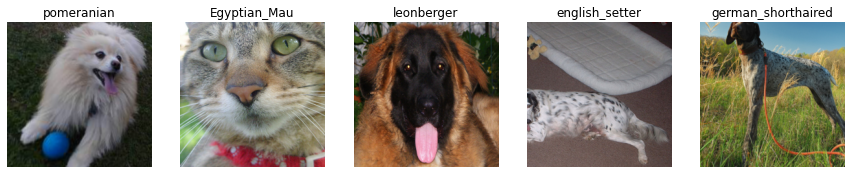

In [14]:
dls.show_batch(nrows=1, ncols=5)

# Model Training

SuggestedLRs(valley=0.0008317637839354575)

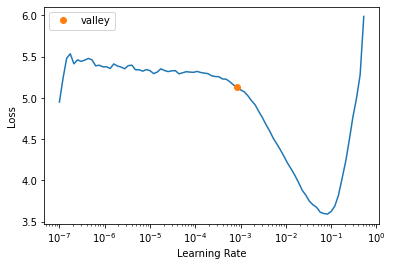

In [15]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.lr_find()

In [16]:
learn.fine_tune(epochs = 5, freeze_epochs = 3, base_lr = 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.089863,1.806613,0.514130,00:23
1,1.868648,0.491928,0.839130,00:23
2,1.032010,0.337932,0.884783,00:23


epoch,train_loss,valid_loss,accuracy,time
0,0.619545,0.318202,0.884783,00:30
1,0.563899,0.331771,0.890217,00:30
2,0.447841,0.283406,0.906522,00:30
3,0.337105,0.282108,0.911957,00:29
4,0.271665,0.267984,0.911957,00:29


In [17]:
learn.export("ceClassification.pkl")

# Model Evaluation

In [40]:
predictions, targets = learn.get_preds(reorder = False)

In [41]:
predictions.shape, targets.shape

(torch.Size([920, 37]), torch.Size([920]))

In [49]:
preds = predictions.argmax(dim = 1)

In [52]:
error_points = torch.where(preds != targets)[0]

In [53]:
predictions[0].argmax()

tensor(25)

In [57]:
all_images = list(dls.valid_ds.items.Image)

In [62]:
records = []

for error in error_points:
    pred = predictions[error].argmax().item()
    p, t = dls.vocab[pred], dls.vocab[targets[error].item()]
    name = all_images[error]
    cs = round(predictions[error][pred].item(), 4)
    records.append([name, p, t, cs])

In [63]:
error_df = pd.DataFrame(records, columns = ["Name", "Prediction", "Target", "Conf_Score"])

In [66]:
error_df

,Name,Prediction,Target,Conf_Score
0,english_cocker_spaniel_176.jpg,german_shorthaired,english_cocker_spaniel,0.6078
1,Ragdoll_136.jpg,Birman,Ragdoll,0.9197
2,beagle_123.jpg,basset_hound,beagle,0.6616
3,Bengal_113.jpg,Egyptian_Mau,Bengal,0.6861
4,yorkshire_terrier_121.jpg,havanese,yorkshire_terrier,0.9844
...,...,...,...,...
76,Birman_133.jpg,Siamese,Birman,0.5676
77,english_cocker_spaniel_107.jpg,english_setter,english_cocker_spaniel,0.6441
78,havanese_105.jpg,scottish_terrier,havanese,0.4951
79,american_bulldog_105.jpg,staffordshire_bull_terrier,american_bulldog,0.8390


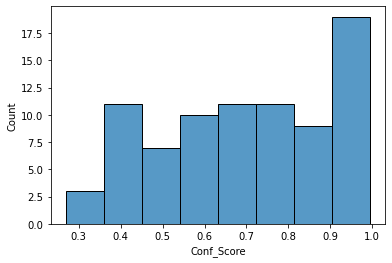

In [69]:
sns.histplot(error_df.Conf_Score);

In [72]:
error_df.to_csv("./artefacts/ce_error_df.csv", index = None)